# Problem Set #3
## Name: Weiwei Zheng

### Problem 1

a) plot a histogram

In [36]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer') 
%matplotlib notebook

income = np.loadtxt('incomes.txt')

<IPython.core.display.Javascript object>


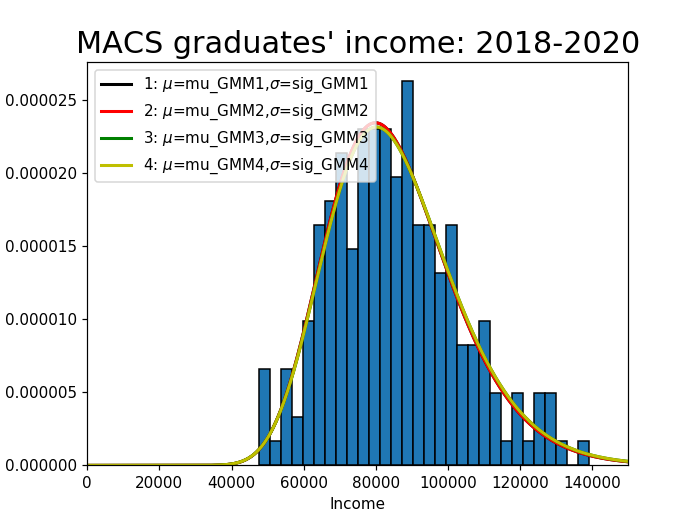

(0, 150000)

In [37]:
#plot the histogram
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title("MACS graduates' income: 2018-2020", fontsize=20)
plt.xlabel('Income')
plt.ylabel('Percent of income')
plt.xlim([0, 150000])

b) Estimate the parameters of the lognormal distribution by GMM. 

i) Use the average income and standard deviation of income as your two moments.

ii) Use the identity matrix as your weighting matrix W^ 

iii) Plot your estimated lognormal PDF against the histogram from part (a).

iv) Report the value of your GMM criterion function at the estimated parameter values.

v) Report and compare your two data moments against your two model moments at the estimated parameter values.

In [38]:
#calculate the data moments of mean and std
def data_moments(xvals):
    '''
    This function computes the mean and standard diviation as the 
    two data moments.
    
    Inputs:
      xvals: vector, income data
    
    Returns: scalar, scalar
    '''
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

In [39]:
#calculate the model moments of mean and std
def model_moments(mu, sigma):
    '''
    This function computes the two model moments for GMM.
    
    Inputs:
      mu: scalar > 0, mean of the lognormally distributed random variable
      sigma: scalar > 0, standard deviation of the lognormally distributed
             random variable
    
    Returns: scalar, scalar
    '''
    mean_model = np.exp(mu + (sigma **2)/2)
    std_model = np.sqrt((np.exp(sigma ** 2)- 1)*np.exp(2 * mu + sigma ** 2))
    
    return mean_model, std_model

In [40]:
def err_vec(xvals, mu, sigma):
    '''
    This function computes the vector of moment errors in percent
    deviation from the data moment vector for GMM.
    
    Inputs:
      xvals: vector, income data
      mu: scalar > 0, mean of the lognormally distributed random variable
      sigma: scalar > 0, standard deviation of the lognormally distributed
             random variable
    
    Return: vector
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])
    err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [41]:
def criterion(params, *args):
    '''
    This function computes the GMM weighted sum of squared moment
    given parameter values and an estimate of the weighting matrix.
    
    Inputs:
      params: (2,) vector, ([mu, sigma])
        mu: scalar > 0, mean of the lognormally distributed random variable
        sigma: scalar > 0, standard deviation of the lognormally distributed
              random variable
      args: length 2 tuple, (xvals, W_hat)
        xvals: vector, values of the lognormally distributed random variable
        W_hat: (2, 2) matrix, estimate of optimal weighting matrix
    
    Return: scalar
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [42]:
# optimize the criterion function
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (income, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None))) #inf
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mu_GMM1= 11.3318807729  sig_GMM1= 0.208696666482


In [43]:
# plot the estimated value pdf
xvals_1 = np.linspace(0.1, 150000, 1000) 
pdf_vals_1 = sts.lognorm.pdf(xvals_1, s = sig_GMM1, scale = np.exp(mu_GMM1))
plt.plot(xvals_1, pdf_vals_1,
         linewidth=2, color='k', label='1: $\mu$=mu_GMM1,$\sigma$=sig_GMM1')
plt.legend(loc='upper left')

In [44]:
# value of GMM criterion function
print("The value of GMM criterion function is", results.fun[0, 0])

The value of GMM criterion function is 6.99555134767e-15


In [45]:
# data moments and model moments
mean_data, std_data = data_moments(income)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1)
err1 = err_vec(income, mu_GMM1, sig_GMM1).reshape(2,)
print('Mean of data =', mean_data, ', Standard deviation of data =', std_data)
print('Mean of model =', mean_model, ', Standard deviation of model =', std_model)
print('Error vector=', err1)

Mean of data = 85276.8236063 , Standard deviation of data = 17992.542128
Mean of model = 85276.81765 , Standard deviation of model = 17992.5413002
Error vector= [ -6.98466510e-08  -4.60108324e-08]


c) Perform the two-step GMM

i) Report your estimates as well as the criterion function value at these estimates

ii) Plot your estimated lognormal PDF against the histogram 

iii) Report and compare data and model moments

In [46]:
# calculate W^2
err1 = err_vec(income, mu_GMM1, sig_GMM1).reshape(2,1)
VCV1 = np.dot(err1, err1.T)/ income.shape[0]
w_hat_2 = lin.pinv(VCV1)

In [48]:
# calculate the estimators
mu_init = mu_GMM1
sig_init = sig_GMM1
params_init = np.array([mu_init, sig_init])
gmm_args = (income, w_hat_2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='TNC', bounds=((1e-10, None), (1e-10, None))) #inf
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2, ' crition function value=', results2.fun[0][0])

mu_GMM2= 11.331880826  sig_GMM2= 0.208696667465  crition function value= 1.49552714848


In [49]:
#plot the estimated pdf
xvals_2 = np.linspace(0.1, 150000, 1000) 
pdf_vals_2 = sts.lognorm.pdf(xvals_2, s = sig_GMM2, scale = np.exp(mu_GMM2))
plt.plot(xvals_2, pdf_vals_2,
         linewidth=2, color='r', label='2: $\mu$=mu_GMM2,$\sigma$=sig_GMM2')
plt.legend(loc='upper left')

In [50]:
# data moments and model moments
mean_data, std_data = data_moments(income)
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2)
err2 = err_vec(income, mu_GMM2, sig_GMM2).reshape(2,)
print('Mean of data =', mean_data, ', Standard deviation of data =', std_data)
print('Mean of model =', mean_model2, ', Standard deviation of model =', std_model2)
print('Error vector=', err2)

Mean of data = 85276.8236063 , Standard deviation of data = 17992.542128
Mean of model = 85276.8221908 , Standard deviation of model = 17992.5423449
Error vector= [ -1.65989447e-08   1.20504692e-08]


d) Now estimate the lognormal PDF to fit the data by GMM using different moments.

i) Use the identity matrix as your estimator for the optimal weighting matrix.

ii) Plot your estimated lognormal PDF 

iii) Report the value of your GMM criterion function at the estimated parameter values. 

iv) Report and compare your three data moments against your three model moments at the estimated parameter values.

In [51]:
# calculate the data moment
def data_moments3(xvals):
    '''
    This function computes the three data moments for GMM.
    
    Inputs:
      xvals: (N,) vector, income data

    Return: three scalars
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >= 75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[(xvals >= 100000)].shape[0] / xvals.shape[0])

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

In [52]:
# calculate the model moment
def model_moments3(mu, sigma):
    '''
    This function computes the three model moments for GMM.

    Inputs:
      mu: scalar > 0, mean of the lognormally distributed random variable
      sigma: scalar > 0, standard deviation of the lognormally distributed
             random variable
    
    Returns: scalar, scalar
    '''
    xfx = lambda x: sts.lognorm.pdf(x, scale = np.exp(mu), s=sigma)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, np.inf)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

In [53]:
# calculate the error vector
def err_vec3(xvals, mu, sigma):
    '''
    This function computes the vector of moment errors in percent
    deviation from the data moment vector for GMM.
    
    Inputs:
      xvals: vector, income data
      mu: scalar > 0, mean of the lognormally distributed random variable
      sigma: scalar > 0, standard deviation of the lognormally distributed
             random variable
    
    Return: vector
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    err_vec = (moms_model - moms_data) / moms_data # need 100 or not
    
    return err_vec

In [54]:
# criterion function
def criterion3(params, *args):
    '''
    This function computes the GMM weighted sum of squared moment
    given parameter values and an estimate of the weighting matrix.
    
    Inputs:
      params: (2,) vector, ([mu, sigma])
        mu: scalar > 0, mean of the lognormally distributed random variable
        sigma: scalar > 0, standard deviation of the lognormally distributed
              random variable
      args: length 2 tuple, (xvals, W_hat)
        xvals: vector, values of the lognormally distributed random variable
        W_hat: (2, 2) matrix, estimate of optimal weighting matrix
    
    Return: scalar
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [55]:
# get the estimate values
W_hat = np.eye(3)
gmm_args = (income, W_hat)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM_3, sig_GMM_3 = results_3.x
print('mu_GMM_3=', mu_GMM_3, ' sig_GMM_3=', sig_GMM_3, ' crition function value=', results_3.fun[0][0])

mu_GMM_3= 11.3356813274  sig_GMM_3= 0.210598453887  crition function value= 2.4902792968e-15


In [56]:
#plot the estimated pdf
xvals_3 = np.linspace(0.1, 150000, 1000) 
pdf_vals_3 = sts.lognorm.pdf(xvals_3, s = sig_GMM_3, scale = np.exp(mu_GMM_3))
plt.plot(xvals_3, pdf_vals_3,
         linewidth=2, color='g', label='3: $\mu$=mu_GMM3,$\sigma$=sig_GMM3')
plt.legend(loc='upper left')

In [57]:
# data moments and model moments
perc_1_data, perc_2_data, perc_3_data = data_moments3(income)
perc_1_model, perc_2_model, perc_3_model = model_moments3(mu_GMM_3, sig_GMM_3)
err3 = err_vec3(income, mu_GMM_3, sig_GMM_3).reshape(3,)
print('In the data, the percent lower than 75 thousand =', perc_1_data, ', betweet 100 and 75 thousand =', perc_2_data,\
     ' higher than 100 thousand =', perc_3_data)
print('In the model, the percent lower than 75 thousand =', perc_1_model, ', betweet 100 and 75 thousand =', 
      perc_2_model, ' higher than 100 thousand =', perc_3_model)
print('Error vector=', err3)

In the data, the percent lower than 75 thousand = 0.3 , betweet 100 and 75 thousand = 0.5  higher than 100 thousand = 0.2
In the model, the percent lower than 75 thousand = 0.3000000038800968 , betweet 100 and 75 thousand = 0.5000000055045689  higher than 100 thousand = 0.19999999061533438
Error vector= [  1.29336560e-08   1.10091378e-08  -4.69233281e-08]


e) Perform the two-step GMM estimator by using your estimates from part(d) 

i) Report your estimates as well as the criterion function value at these estimates.

ii) Plot your estimated lognormal PDF

iii) Report and compare your three data moments against your three model moments

In [58]:
# calculate W^2
err3 = err_vec3(income, mu_GMM_3, sig_GMM_3).reshape(3, 1)
VCV3 = np.dot(err3, err3.T)/ income.shape[0]
w_hat_2 = lin.pinv(VCV3)

In [60]:
# calculate the estimators
mu_init = mu_GMM_3
sig_init = sig_GMM_3
params_init = np.array([mu_init, sig_init])
gmm_args = (income, w_hat_2)
results4 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None))) #inf
mu_GMM4, sig_GMM4 = results4.x
print('mu_GMM4=', mu_GMM4, ' sig_GMM4=', sig_GMM4, ' crition function value=', results4.fun[0][0])

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


mu_GMM4= 11.3356813288  sig_GMM4= 0.210598455768  crition function value= 68.5386869157


In [61]:
#plot the estimated pdf
xvals_4 = np.linspace(0.1, 150000, 1000) 
pdf_vals_4 = sts.lognorm.pdf(xvals_4, s = sig_GMM4, scale = np.exp(mu_GMM4))
plt.plot(xvals_4, pdf_vals_4,
         linewidth=2, color='y', label='4: $\mu$=mu_GMM4,$\sigma$=sig_GMM4')
plt.legend(loc='upper left')

In [62]:
# data moments and model moments
perc_1_data, perc_2_data, perc_3_data = data_moments3(income)
perc_1_model_2, perc_2_model_2, perc_3_model_2 = model_moments3(mu_GMM4, sig_GMM4)
err4 = err_vec3(income, mu_GMM4, sig_GMM4).reshape(3,)
print('In the data, the percent lower than 75 thousand =', perc_1_data, ', betweet 100 and 75 thousand =', perc_2_data,\
     ' higher than 100 thousand =', perc_3_data)
print('In the model, the percent lower than 75 thousand =', perc_1_model_2, ', betweet 100 and 75 thousand =', 
      perc_2_model_2, ' higher than 100 thousand =', perc_3_model_2)
print('Error vector=', err4)

In the data, the percent lower than 75 thousand = 0.3 , betweet 100 and 75 thousand = 0.5  higher than 100 thousand = 0.2
In the model, the percent lower than 75 thousand = 0.3000000031956243 , betweet 100 and 75 thousand = 0.5000000022221961  higher than 100 thousand = 0.19999999458217968
Error vector= [  1.06520811e-08   4.44439219e-09  -2.70891017e-08]


f) Which of the four estimations from parts (b), (c), (d), and (e) fits the data best?

In [64]:
print("Error vector in d)", err3.reshape(3,), " error vector in e)", err4)

Error vector in d) [  1.29336560e-08   1.10091378e-08  -4.69233281e-08]  error vector in e) [  1.06520811e-08   4.44439219e-09  -2.70891017e-08]


The estimation which fits the data best should be that in e). Compared with b) and c), d) and e) use more moments to estimate the parameters. And compared with d), the absolute value of error vector of e), which uses the weighting matrix to estimate the parameters is smaller. 

### Problem 2

a) estimate parameters b0, b1, b2, b3, report your estimates and report the value of your GMM criterion function.


In [65]:
import pandas as pd
import scipy.stats as sts
# import data
df = pd.read_csv('sick.txt')

In [66]:
def model_moment(b0, b1, b2, b3, age, children, temp_winter):
    '''
    This function computes the model moment for GMM.
    
    Inputs:
      b0: (scalar) constant
      b1: (scalar) coefficient of age
      b2: (scalar) coefficient of children
      b3: (scalar) coefficient of winter temperature
      age: (vector) age
      children: (vector) number of children
      temp_winter: (vector) temperature of winter
      

    Return: vector
    '''
    
    mod_mom = b0 + b1 * age + b2 * children + b3 * temp_winter

    return mod_mom

In [67]:
def error_vec_lin(sick, b0, b1, b2, b3, age, children, temp_winter):
    '''
    This function computes the error vector from the dataset.
    
    Inputs:
      sick: (vector)the number of weeks being sick
      b0: (scalar) constant
      b1: (scalar) coefficient of age
      b2: (scalar) coefficient of children
      b3: (scalar) coefficient of winter temperature
      age: (vector) age
      children: (vector) number of children
      temp_winter: (vector) temperature of winter
    
    Return: vector
    '''
    
    error = sick - model_moment(b0, b1, b2, b3, age, children, temp_winter)
    
    return error      

In [68]:
def criterion(params, *args):
    '''
    This function computes the square of error vector. 
    
    Inputs:
      params: (4,) vector, ([b0, b1, b2, b3])
        b0: (scalar) constant
        b1: (scalar) coefficient of age
        b2: (scalar) coefficient of children
        b3: (scalar) coefficient of winter temperature
      args: length 5 tuple, (sick, age, children, temp_winter, W_hat)
        sick: (vector)the number of weeks being sick
        age: (vector) age
        children: (vector) number of children
        temp_winter: (vector) temperature of winter
        W_hat: (200, 200) matrix, estimate of optimal weighting matrix
    
    Return: scalar
    '''
    b0, b1, b2, b3 = params
    sick, age, children, temp_winter, w_hat = args
    
    err = error_vec_lin(sick, b0, b1, b2, b3, age, children, temp_winter) 
    crit_val = np.dot(np.dot(err.T, w_hat), err)
    
    return crit_val

In [69]:
# calculate the estimates
initial_params = np.array([1, 0, 0, 0])
w_hat = np.eye(df.shape[0])
gmm_args = (df["sick"], df["age"], df["children"], df["avgtemp_winter"], w_hat)
results_lin = opt.minimize(criterion, initial_params, args=(gmm_args))
b0_GMM, b1_GMM, b2_GMM, b3_GMM = results_lin.x 
print("b0 =", b0_GMM, " b1 =", b1_GMM, " b2 = ", b2_GMM, " b3 = ", b3_GMM, 
      "value of GMM function =", results_lin.fun)

b0 = 0.251646391614  b1 = 0.0129333505472  b2 =  0.400502042642  b3 =  -0.00999167346007 value of GMM function = 0.0018212901365710831
